### Data Preprocessing

#### Imports

In [17]:
import kagglehub
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import numpy as np
import math
from imblearn.combine import SMOTETomek

#### Download ISIC-2019
1. Download the Training Data and Training Ground Truth from [this link](https://challenge.isic-archive.com/data/#2019) OR by running the script below.
2. Unzip the zip file(s).
3. Move the downloaded folders to backend/data/ISIC-2019.

In [ ]:
# Download latest version
path = kagglehub.dataset_download("andrewmvd/isic-2019")

print("Path to dataset files:", path)

#### Download ISIC-2020
1. Download the Training Data and Training Ground Truth from [this link](https://challenge.isic-archive.com/data/#2020).
2. Unzip the zip file(s).
3. Move the downloaded folders to backend/data/ISIC-2020.

#### Filter Functions
Hair Removal and Noise Reduction

In [10]:
def filter_all_images(input_folder: str, output_folder: str, num: int=None) -> None:
    """Apply all filtering functions to jpg files in input_folder."""
    num_filtered = 0
    for file_name in os.listdir(input_folder):
        try:
            if file_name.endswith(".jpg"):
                print(f"Processing {file_name}...")
                filter_image(input_folder, output_folder, file_name)
                num_filtered += 1
                if num and num_filtered >= num:
                    print(f"Processed {num_filtered} images. Stopping.")
                    break
        except Exception as e:
            print(f"Error processing image {file_name}: {e}")

def filter_image(input_folder: str, output_folder: str, file_name: str) -> None:
    """Apply all filtering functions to a single image file."""
    image_path = os.path.join(input_folder, file_name)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image from {image_path}")
    else:
        image_hr = hair_removal(image)
        image_nr = noise_reduction(image_hr)

        image_final = image_nr
        output_path = os.path.join(output_folder, file_name)
        cv2.imwrite(output_path, image_final)

def hair_removal(image: np.ndarray) -> np.ndarray:
    """Apply hair removal filter to the image using the Dull Razor algorithm."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))  # creates a kernel for morphing
    blackhat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, kernel)  # apply blackhat filter (highlights dark regions)
    bhg = cv2.GaussianBlur(blackhat, (9, 9), cv2.BORDER_REPLICATE)  # smooths image
    _, mask = cv2.threshold(bhg, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # creates a binary mask to detect hair-like structure
    inpainted_image = cv2.inpaint(image, mask, 4, cv2.INPAINT_TELEA)
    return inpainted_image

def noise_reduction(image: np.ndarray) -> np.ndarray:
    """Apply noise reduction to the image using Median Filtering and Bilateral Filtering."""
    image_mf = cv2.medianBlur(image, 5)  # Apply median filter to reduce salt and pepper noise
    image_bf = cv2.bilateralFilter(image_mf, d=17, sigmaColor=100, sigmaSpace=100)  # Apply bilateral filter to reduce noise while preserving edges
    return image_bf

#### Preprocessing Function
Resize and SMOTE-Tomek Oversampling

In [18]:
def resize_oversample_images(output_folder: str, data_frame: pd.DataFrame, image_size=(224, 224)) -> None:
    """
    Oversample melanoma images using SMOTE-Tomek.

    output_folder: Path to the folder with filtered images and where upsampled images will be saved.
    data_frame: DataFrame containing image file names, melanoma (0 or 1), and paths.
    output_csv_path: Path to save the updated CSV file.
    image_size: Target size (width, height) for resized images.
    """
    # Load melanoma images and their labels
    melanoma_df = data_frame[data_frame['melanoma'] == 1]
    non_melanoma_df = data_frame[data_frame['melanoma'] == 0]

    melanoma_images = []
    melanoma_labels = []

    for image_path in melanoma_df['path']:
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load as RGB
        if image is not None:
            resized_image = cv2.resize(image, image_size)  # Resize to target size
            melanoma_images.append(resized_image.flatten())  # Flatten the image
            melanoma_labels.append(1)  # Label for melanoma

    non_melanoma_images = []
    non_melanoma_labels = []

    for image_path in non_melanoma_df['path']:
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load as RGB
        if image is not None:
            resized_image = cv2.resize(image, image_size)  # Resize to target size
            non_melanoma_images.append(resized_image.flatten())  # Flatten the image
            non_melanoma_labels.append(0)  # Label for non-melanoma

    # Combine melanoma and non-melanoma data
    X = np.array(melanoma_images + non_melanoma_images)
    y = np.array(melanoma_labels + non_melanoma_labels)

    # Apply SMOTE-Tomek
    smote_tomek = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

    synthetic_data = {"image_name": [], "melanoma": [], "path": []}
    for i, (image_data, label) in enumerate(zip(X_resampled, y_resampled)):
        reshaped_image = image_data.reshape(image_size[0], image_size[1], 3)  # Reshape to original size
        output_image_path = os.path.join(output_folder, f"synthetic_{i}.jpg")
        cv2.imwrite(output_image_path, reshaped_image)  # Save the image
        synthetic_data["image_name"].append(f"synthetic_{i}")
        synthetic_data["melanoma"].append(label)
        synthetic_data["path"].append(output_image_path)

    # Save the updated DataFrame
    synthetic_df = pd.DataFrame(synthetic_data)
    combined_df = pd.concat([data_frame, synthetic_df], ignore_index=True)

    return combined_df

#### View Functions

In [ ]:
def num_melanoma(data_frame: pd.DataFrame) -> int:
    # Count number of melanoma vs non-melanoma
    melanoma_count = data_frame[data_frame["melanoma"] == 1].shape[0]
    non_melanoma_count = data_frame[data_frame["melanoma"] == 0].shape[0]

    print(f"\nMelanoma images: {melanoma_count}")
    print(f"Non-Melanoma images: {non_melanoma_count}")

    # Percent distribution
    print("\nmelanoma column class distribution (%):")
    print(data_frame["melanoma"].value_counts(normalize=True) * 100)

def view_images(folder: str, num=None) -> None:
    """
    View a subset of images from the dataset.

    folder: Path to the folder containing images
    num: Number of images to display. If None, display all images in the folder.
    """
    image_files = [f for f in os.listdir(folder) if f.endswith('.jpg') and os.path.isfile(os.path.join(folder, f))]
    if num is None:
        num = len(image_files)
    n_rows = math.ceil(num / 5)
    n_cols = 5
    plt.figure(figsize=(n_cols * 3, n_rows * 5))  # Adjust figure size dynamically
    for i, image_file in enumerate(image_files[:num]):
        image_path = os.path.join(folder, image_file)
        img = mpimg.imread(image_path)
        
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        plt.title(image_file, fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#### Path Setup

In [ ]:
isic_2019_base_path = '../../data/ISIC-2019'
isic_2019_images_folder = os.path.join(isic_2019_base_path, 'ISIC_2019_Training_Input', 'ISIC_2019_Training_Input')
isic_2019_labels_file = os.path.join(isic_2019_base_path, 'ISIC_2019_Training_GroundTruth.csv')

isic_2020_base_path = '../../data/ISIC-2020'
isic_2020_images_folder = os.path.join(isic_2020_base_path, 'train')
isic_2020_labels_file = os.path.join(isic_2020_base_path, 'ISIC_2020_Training_GroundTruth.csv')

output_folder = '../../data/preprocessed_images'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
output_labels_file = os.path.join(output_folder, 'ISIC_2019_2020_Training_Oversampled.csv')

#### View Images

ISIC 2019 images
Total .jpg files found: 25331
Sample image names: ['ISIC_0030858.jpg', 'ISIC_0030680.jpg', 'ISIC_0033389.jpg', 'ISIC_0032097.jpg', 'ISIC_0054312.jpg']

Images before preprocessing:


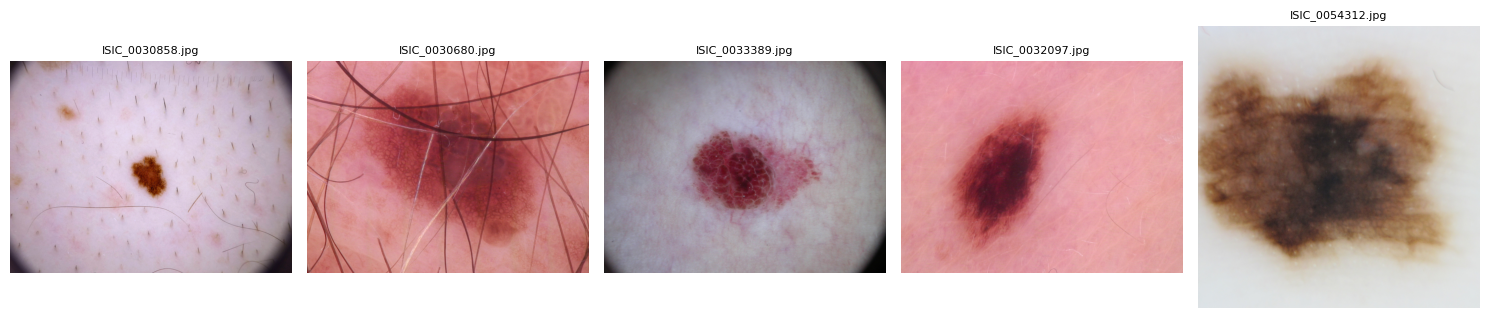

In [7]:
# === Check Images from ISIC 2019 ===
# List only .jpg image files (ignore folders)
isic_2019_files = [f for f in os.listdir(isic_2019_images_folder) if f.endswith('.jpg') and os.path.isfile(os.path.join(isic_2019_images_folder, f))]

print("ISIC 2019 images")
print("Total .jpg files found:", len(isic_2019_files))
print("Sample image names:", isic_2019_files[:5])

# === Visualize First 5 Images ===
print("\nImages before preprocessing:")
view_images(isic_2019_images_folder, 5)

ISIC 2020 images
Total .jpg files found: 33126
Sample image names: ['ISIC_4927075.jpg', 'ISIC_7764987.jpg', 'ISIC_4693693.jpg', 'ISIC_3152541.jpg', 'ISIC_5309101.jpg']

Images before preprocessing:


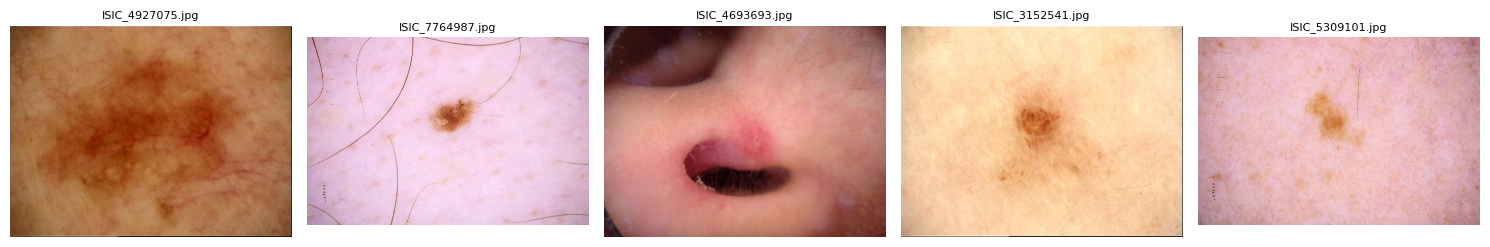

In [8]:
# === Check Images from ISIC 2020 ===
# List only .jpg image files (ignore folders)
isic_2020_files = [f for f in os.listdir(isic_2020_images_folder) if f.endswith('.jpg') and os.path.isfile(os.path.join(isic_2020_images_folder, f))]

print("ISIC 2020 images")
print("Total .jpg files found:", len(isic_2020_files))
print("Sample image names:", isic_2020_files[:5])

# === Visualize First 5 Images ===
print("\nImages before preprocessing:")
view_images(isic_2020_images_folder, 5)

#### Filter All Images


Testing by filtering 5 images from ISIC 2019...
Processing ISIC_0030858.jpg...
Processing ISIC_0030680.jpg...
Processing ISIC_0033389.jpg...
Processing ISIC_0032097.jpg...
Processing ISIC_0054312.jpg...
Processed 5 images. Stopping.


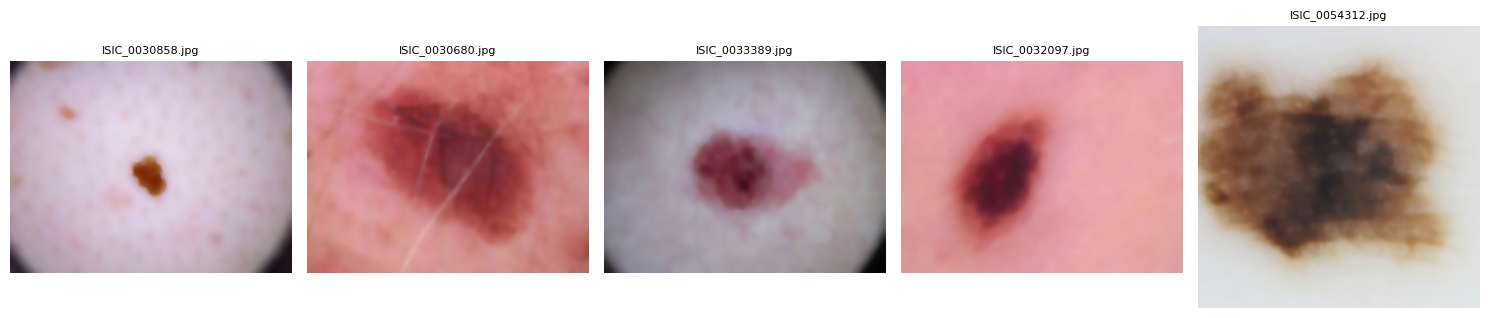

In [11]:
# Testing with 5 images from ISIC 2019
print("\nTesting by filtering 5 images from ISIC 2019...")
filter_all_images(isic_2019_images_folder, output_folder, 5)

view_images(output_folder, 5)

In [ ]:
# Filter all images from ISIC 2019
print("\nFiltering all ISIC 2019 images...")
filter_all_images(isic_2019_images_folder, output_folder)

In [ ]:
# Filter all images from ISIC 2020
print("\nFiltering all ISIC 2020 images...")
filter_all_images(isic_2020_images_folder, output_folder)

In [ ]:
# Preview 10 filtered images
print("\nPreview of filtered images:")
view_images(output_folder, 10)

#### Load DataFrame

In [12]:
# === Load ISIC 2019 Labels ===
isic_2019_df = pd.read_csv(isic_2019_labels_file)[['image', 'MEL']]
print("\nISIC 2019 labels preview:")
print(isic_2019_df.head())

print("Renaming columns and adding path...")
isic_2019_df.rename(columns={'image': 'image_name', 'MEL': 'melanoma'}, inplace=True)
isic_2019_df['path'] = isic_2019_df['image_name'].apply(lambda file_name: os.path.join(output_folder, f"{file_name}.jpg"))
print(isic_2019_df.head())

# === Melanoma vs. Non-Melanoma ===
num_melanoma(isic_2019_df)


ISIC 2019 labels preview:
          image  MEL
0  ISIC_0000000  0.0
1  ISIC_0000001  0.0
2  ISIC_0000002  1.0
3  ISIC_0000003  0.0
4  ISIC_0000004  1.0
Renaming columns and adding path...
     image_name  melanoma                                             path
0  ISIC_0000000       0.0  ../../data/preprocessed_images/ISIC_0000000.jpg
1  ISIC_0000001       0.0  ../../data/preprocessed_images/ISIC_0000001.jpg
2  ISIC_0000002       1.0  ../../data/preprocessed_images/ISIC_0000002.jpg
3  ISIC_0000003       0.0  ../../data/preprocessed_images/ISIC_0000003.jpg
4  ISIC_0000004       1.0  ../../data/preprocessed_images/ISIC_0000004.jpg

Melanoma images: 4522
Non-Melanoma images: 20809

MEL column class distribution (%):
melanoma
0.0    82.148356
1.0    17.851644
Name: proportion, dtype: float64


In [13]:
# === Load ISIC 2020 Labels ===
isic_2020_df = pd.read_csv(isic_2020_labels_file)[['image_name', 'diagnosis']]
print("\nISIC 2020 labels preview:")
print(isic_2020_df.head())

print("Renaming columns, adding one-hot encoding, and adding path...")
isic_2020_df.rename(columns={'diagnosis': 'melanoma'}, inplace=True)
isic_2020_df['melanoma'] = isic_2020_df['melanoma'].apply(lambda x: 1 if x == 'melanoma' else 0)  # Convert to binary
isic_2020_df['path'] = isic_2020_df['image_name'].apply(lambda file_name: os.path.join(output_folder, f"{file_name}.jpg"))
print(isic_2020_df.head())

# === Melanoma vs. Non-Melanoma ===
num_melanoma(isic_2020_df)  # Display the number of melanoma vs non-melanoma images


ISIC 2020 labels preview:
     image_name diagnosis
0  ISIC_2637011   unknown
1  ISIC_0015719   unknown
2  ISIC_0052212     nevus
3  ISIC_0068279   unknown
4  ISIC_0074268   unknown
Renaming columns, adding one-hot encoding, and adding path...
     image_name  melanoma                                             path
0  ISIC_2637011         0  ../../data/preprocessed_images/ISIC_2637011.jpg
1  ISIC_0015719         0  ../../data/preprocessed_images/ISIC_0015719.jpg
2  ISIC_0052212         0  ../../data/preprocessed_images/ISIC_0052212.jpg
3  ISIC_0068279         0  ../../data/preprocessed_images/ISIC_0068279.jpg
4  ISIC_0074268         0  ../../data/preprocessed_images/ISIC_0074268.jpg

Melanoma images: 584
Non-Melanoma images: 32542

MEL column class distribution (%):
melanoma
0    98.237034
1     1.762966
Name: proportion, dtype: float64


In [14]:
# === Combine ISIC 2019 and 2020 DataFrames ===
combined_df = pd.concat([isic_2019_df, isic_2020_df], ignore_index=True)
print("\nCombined DataFrame preview:")
print(combined_df.head())
print("Total images in combined DataFrame:", len(combined_df))

# Save the combined DataFrame to CSV file
combined_df.to_csv(output_labels_file)
print(f"Combined DataFrame saved to {output_labels_file}")


Combined DataFrame preview:
     image_name  melanoma                                             path
0  ISIC_0000000       0.0  ../../data/preprocessed_images/ISIC_0000000.jpg
1  ISIC_0000001       0.0  ../../data/preprocessed_images/ISIC_0000001.jpg
2  ISIC_0000002       1.0  ../../data/preprocessed_images/ISIC_0000002.jpg
3  ISIC_0000003       0.0  ../../data/preprocessed_images/ISIC_0000003.jpg
4  ISIC_0000004       1.0  ../../data/preprocessed_images/ISIC_0000004.jpg
Total images in combined DataFrame: 58457
Combined DataFrame saved to ../../data/preprocessed_images/ISIC_2019_2020_Training_Oversampled.csv


#### Data Augmentation

In [ ]:
print("\nApplying data augmentation to balance the dataset...")
combined_df = resize_oversample_images(output_folder, combined_df, output_labels_file)
print("Total images in preprocessed DataFrame:", len(combined_df))

In [ ]:
combined_df.to_csv(output_labels_file)
print(f"Updated CSV saved to {output_labels_file}")

#### Preview Augmented Dataset

In [ ]:
print("\nBalanced dataset preview:")
print(combined_df.head())
num_melanoma(combined_df)  # Display the number of melanoma vs non-melanoma images